In [14]:
%load_ext pycodestyle_magic

In [15]:
%flake8_on

# PROJET 5 : Catégorisation automatiquement des questions

## SOMMAIRE  <a class="anchor" id="sommaire"></a>
## [CONTEXTE DU PROJET](#1)<a class="anchor" id="sommaire"></a>
## [LES DONNEES DU PROJET](#2)<a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>

## [MISSION 3: PREPROCESSING](#11)<a class="anchor" id="sommaire"></a>
### [M3-1 : Préparation des input et output : ](#12)<a class="anchor" id="sommaire"></a>
### [M3-2 : Séparation de jeu de données de test et d'entrainement : ](#13)<a class="anchor" id="sommaire"></a>

## [MISSION 4: APPROCHE NON-SUPERVISEE](#15)<a class="anchor" id="sommaire"></a>
### [M4-1 : Modélisation avec algorithme LDA : ](#16)<a class="anchor" id="sommaire"></a>
### [M5-1 : Modélisation avec algorithme NMF : ](#17)<a class="anchor" id="sommaire"></a>

## [MISSION 5: APPROCHE SUPERVISEE](#20)<a class="anchor" id="sommaire"></a>


--------------------------------------------------------

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

Stack Overflow est un site de questions-réponses liées au développement informatique.
Les tags nous permettent de retrouver facilement la réponse à une question posée, pourtant ce n'est pas évident de trouver des tags associés à notre question.
Donc il était intéressant de développer un application qui suggererait automatiquement plusieurs tags pertinents à partir d'une question posée. 

## [LES DONNEES DU PROJET](#sommaire)<a class="anchor" id="2"></a>

Stack Overflow propose un outil d’export de données en ligne sur - "stackexchange explorer" :
On retrouve 29 tables au total, mais pour notre besoin, la table 'Posts' suffira parce qu'elle contient la liste des questions posées avec les tags associés, le nombre de réponse, la note de pertinence associée à la question,...

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
import os
import re
import warnings
from time import time
from utils.functions import custom_tokenize, print_top_words
from utils.functions import predictTag, vectorizeInputTest
from utils.functions import remove_stopword, cleanText, pattern_searcher
from nltk.stem import WordNetLemmatizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, jaccard_score

In [11]:
# Configuration affichage
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Sauvegarde des données des tags et mots pour la suite :

## [MISSION 3: PREPROCESSING](#sommaire)<a class="anchor" id="11"></a>

#### Récuperation des données texte :

Exportons les données stockées dans des fichiers texte :

- data/tags_words_tokens.csv : contient les données de base
- data/Backup/top1000_words.csv : contient les données de top 1000 des mots 
- data/Backup/top100_tags.csv : contient les données de top 100 des tags
- data/Backup/X_data.csv
- data/Backup/y_data.csv

In [12]:
data_preprocess = pd.read_csv('data/tags_words_tokens.csv', sep='\t', engine='python')
data_preprocess.drop(['Unnamed: 0'], axis=1, inplace=True)

top1000words_exp = pd.read_csv('data/Backup/top1000_words.csv',
                               header=None, index_col=0,
                               squeeze=True).to_dict()
top100tags_exp = pd.read_csv('data/Backup/top100_tags.csv',
                             header=None, index_col=0,
                             squeeze=True).to_dict()

### [M3-1 : Préparation des input et output : ](#sommaire)<a class="anchor" id="12"></a>

#### vectorisation de corpus par Bag Of Words:

In [13]:
# Corpus (=X) en entrée on aura un ensmble de mots -> Body + Title
X_data = pd.read_csv('data/Backup/X_data.csv', sep='\t',engine='python')
X_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [14]:
X_data

,use,way,like,using,file,code,one,would,get,string,class,want,method,function,know,python,object,need,ive,example,java,git,new,value,question,difference,javascript,work,best,list,table,time,return,make,something,line,c++,also,dont,type,data,used,application,script,text,set,number,user,find,name,good,command,database,error,create,window,int,server,public,answer,could,jquery,two,page,thing,variable,test,image,http,sql,possible,change,static,problem,see,following,key,array,option,element,without,language,run,looking,project,different,whats,seems,div,web,solution,better,doesnt,call,result,simple,exception,add,another,case,php,really,version,form,branch,found,library,say,directory,feature,column,html,multiple,bit,trying,read,first,var,cant,select,view,program,think,edit,current,memory,programming,able,people,look,url,understand,linux,write,always,event,mean,output,thread,property,service,however,given,check,even,reference,mysql,many,tool,instead,standard,content,etc,print,end,system,query,working,update,process,anyone,item,lot,pattern,repository,.net,well,please,point,source,specific,foo,else,date,browser,book,idea,reason,tried,interface,practice,request,give,take,right,sure,much,design,app,convert,single,field,still,private,main,show,running,post,done,void,based,order,site,since,merge,module,Unnamed: 207,commit,performance,access,remove,stack,instance,size,statement,control,may,tag,message,long,put,loop,import,include,path,someone,input,row,seen,start,parameter,character,thats,called,try,open,seem,visual,client,issue,back,resource,framework,true,word,far,let,non,hidden,information,...,modify,easily,distance,constraint,entry,complex,commits,src=,inheritance,stream,jar,top,img,redirect,iframe,.e+,plugins,username,choose,safe,dom,direction,hoping,beginner,graph,guess,layout,fairly,functional,turn,release,require,couple,linked,nothing,parse,position,constant,foreign,dialog,prevent,almost,expect,dynamically,none,checked,comparison,reflection,worked,body,extra,disk,engine,oracle,device,value=,normal,specify,firefox,logging,signed,completely,fill,regex,center,example.com,revision,extend,plugin,deal,appreciated,disable,major,thus,grid,accepted,reset,ideally,naming,convention,boolean,grep,terminal,sdk,oriented,backup,undefined,declare,submit,host,ignore,letter,postgresql,bin,keyboard,shared,achieve,val,maximum,failed,style=,openerguid,session,authentication,love,business,requirement,sense,necessary,ascii,port,behind,ienumerable,close,injection,although,quickly,looked,share,fully,special,batch,ssh,internal,outer,talking,card,resolve,previous,queue,happen,modified,somewhere,zero,label,proper,mention,generated,guideline,mark,continue,preferably,likely,worth,recursion,follow,past,checkout,mutex,manual,kill,attempt,effective,bunch,choice,download,lisp,recursive,opinion,aspect,__init__,logic,external,seek,str,resize,history,description,passing,warning,proxy,currencytype,+.e+j,lambda,hand,iterate,trouble,area,podcast,mostly,storing,finding,moment,additional,console,wasnt,defining,setup,returned,operating,super,alert,info,production,behavior,arraylist,unable,install,collision,lib,hear,spring,month,license,remember,protected,official,beginning,viewmodel,recommend,everyone,develop,leave,bug,along,anonymous,yield,namespace,assuming,scope,today,developing,containing,accomplish,decimal,simplest,initialize,finally,obviously,youre,gcc,shouldnt,suppose,plain,fit,hashmap,depending,strategy,trigger,enter,scripting,shortcut,boost,wait,minute,meant,slow,dbo,calculate,believe
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### vectorisation des tags par MultiLabelBinarizer :

In [15]:
# 4.1 Tags (=y)
y_data = pd.read_csv('data/Backup/y_data.csv', sep='\t',engine='python')
y_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [16]:
y_data

,c,python,javascript,java,c++,.net,html,git,jquery,sql,php,sql-server,language-agnostic,string,css,mysql,oop,algorithm,ios,bash,linux,performance,database,windows,objective-c,version-control,shell,multithreading,arrays,design-patterns,cocoa-touch,list,vim,iphone,c++-faq,regex,datetime,http,unix,tsql,command-line,security,unit-testing,svn,data-structures,asp.net,android,terminology,image,rest,ruby,visual-studio,asp.net-mvc,file,exception,database-design,linq,scripting,macos,inheritance,generics,django,ajax,dictionary,debugging,pointers,class,batch-file,reflection,loops,syntax,wpf,memory,collections,memory-management,variables,dom,url,vi,hidden-features,static,editor,eclipse,enums,constructor,xml,cocoa,coding-style,date,json,browser,object,optimization,naming-conventions,function,struct,random,functional-programming,math,templates
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2101,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Le resultat est une matrice de (8292, 100) car nous avons 8292 lignes et 100 (tags) nouvelles colonnes.

### [M3-2 : Séparation de jeu de données de test et d'entrainement : ](#sommaire)<a class="anchor" id="13"></a>

Nous allons utiliser 80% des données pour l'entrainement et 20% pour le test

In [17]:
# Split train and test :
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1)

## [MISSION 4: APPROCHE NON-SUPERVISEE](#sommaire)<a class="anchor" id="15"></a>

In [41]:
n_samples = 0.8
n_features = 1000
n_components = 10
n_top_words = 10
corpus = data_preprocess['words_tokens']
dataset = corpus.tolist()
data_samples = dataset[:int(len(dataset)*n_samples)]
test_samples = dataset[int(len(dataset)*n_samples):]


def dummy(doc):
    return doc

### [M4-1 : Modélisation avec algorithme LDA : ](#sommaire)<a class="anchor" id="16"></a>

LDA (Latent Dirichlet Allocation) est une méthode non-supervisée qui consiste à classer chaque mot dans une categorie ou sujet(topic) qui lui concerne automatiquement.

In [46]:
corpus
# print('Type of listOfNames: ', type(corpus))

0       ['calculate', 'someone', 'age', 'based', 'date...
1       ['calculate', 'relative', 'time', 'given', 'sp...
2       ['determine', 'user', 'timezone', 'standard', ...
3       ['best', 'way', 'allow', 'plugins', 'php', 'ap...
4       ['versioning', 'sql', 'server', 'database', 'w...
                              ...                        
2099    ['load', 'uiview', 'using', 'nib', 'file', 'cr...
2100    ['javascript', 'garbage', 'collection', 'javas...
2101    ['correctly', 'clean', 'python', 'object', 'cl...
2102    ['generate', 'gcc', 'debug', 'symbol', 'outsid...
2103    ['call', 'android', 'contact', 'list', 'making...
Name: words_tokens, Length: 2104, dtype: object

In [44]:
dataset
# print('Type of listOfNames: ', type(dataset))

["['calculate', 'someone', 'age', 'based', 'datetime', 'type', 'birthday', 'given', 'datetime', 'representing', 'person', 'birthday', 'calculate', 'age', 'year']",
 "['calculate', 'relative', 'time', 'given', 'specific', 'datetime', 'value', 'display', 'relative', 'time', 'like', 'hour', 'ago', 'day', 'ago', 'month', 'ago']",
 "['determine', 'user', 'timezone', 'standard', 'way', 'web', 'server', 'able', 'determine', 'user', 'timezone', 'within', 'web', 'page', 'perhaps', 'http', 'header', 'part', 'user', 'agent', 'string']",
 "['best', 'way', 'allow', 'plugins', 'php', 'application', 'starting', 'new', 'web', 'application', 'php', 'time', 'around', 'want', 'create', 'something', 'people', 'extend', 'using', 'plugin', 'interface', 'one', 'writing', 'hook', 'code', 'plugins', 'attach', 'specific', 'event']",
 "['versioning', 'sql', 'server', 'database', 'want', 'get', 'database', 'version', 'control', 'anyone', 'advice', 'recommended', 'article', 'get', 'started', 'ill', 'always', 'want

In [23]:
# Use tf (raw term count) features for LDA.
print("Extraction des features pour LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                tokenizer=dummy,
                               preprocessor=dummy, analyzer='word')
tf = tf_vectorizer.fit_transform(data_samples)
tf_test = tf_vectorizer.transform(test_samples)
print()

print("Fit  du modele LDA avec tf features, "
      "n_samples=%d and n_features=%d ..."
      % (n_samples, n_features))
lda = LDA(n_components=n_components, max_iter=5,
          learning_method='online', learning_offset=50.,
          random_state=0)
lda.fit(tf)

print("\nLes topics du modele LDA :")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extraction des features pour LDA...

Fit  du modele LDA avec tf features, n_samples=0 and n_features=1000 ...

Les topics du modele LDA :
Topic #0: m g p h y w b f v k
Topic #1: x p h g m w k f y v
Topic #2: + f p m g b v w k *
Topic #3: : w g k p Ã Â v £ f
Topic #4: p j y b v g m h w f
Topic #5: . f v p = m w g h y
Topic #6: * h ½ Å ¿ ï “ v g f
Topic #7: ^ . ¦ k z £ + j œ â
Topic #8: _ y q m z h b . f p
Topic #9: ~ g q h j ¤ ¥ “ p ½



On peut ici imaginer que :
- le topic 1 serait lié à des questions sur le html
- le topic 2 serait lié à des questions sur des gestions de versionning

#### La performance du modèle et recherche de nombre de topics optimal :

Diagnostiquer les performances du modèle avec perplexité et log-vraisemblance :

Un modèle avec une probabilité logarithmique plus élevée et une perplexité moindre est considéré comme bon

Voyons ce que ça donne sur notre modèle:

In [33]:
# Calcul de perplexity avec (5,10,...,30 topics) :
output = pd.DataFrame(columns=['nbrTopic', 'perplexity', 'loglikelihood'])
for i in range(5, 150, 20):
    number_topics = i
    lda_perplexity = LDA(n_components=number_topics, max_iter=5,
                         learning_method='online',
                         learning_offset=50., random_state=0)
    lda_perplexity.fit(tf)
    train_gamma = lda_perplexity.transform(tf)
    test_gamma = lda_perplexity.transform(tf_test)
    news_lda = lda_perplexity.fit(train_gamma)
    dictionary = {"nbrTopic": i,
                  "perplexity": news_lda.perplexity(test_gamma),
                  "loglikelihood": news_lda.score(test_gamma)
                 }
    output = output.append(dictionary, ignore_index=True)
output.head(10)

,nbrTopic,perplexity,loglikelihood
0,5.0,13.621365,-2606.416202
1,25.0,894.344693,-6782.499081
2,45.0,6222.452302,-8718.447530
3,65.0,49335.446425,-10784.785300
4,85.0,132919.510912,-11773.904045
5,105.0,9764.433429,-9168.128817
6,125.0,25245.117457,-10116.115272
7,145.0,35388.937928,-10453.206253


15:18: E124 closing bracket does not match visual indentation


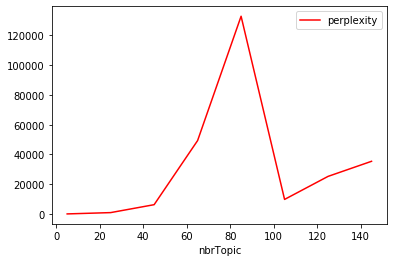

<Figure size 1440x720 with 0 Axes>

In [34]:
# Representation graphique de scores de topic
ax = plt.gca()
output.plot(kind='line', x='nbrTopic',
            y='perplexity', color='red', ax=ax)
plt.figure(figsize=(20, 10))
plt.show()

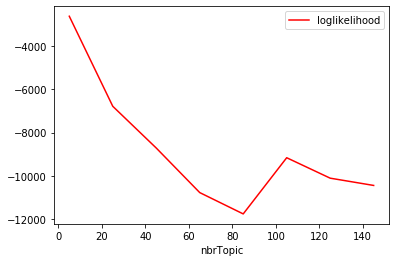

<Figure size 1440x720 with 0 Axes>

In [35]:
# Representation graphique de scores de loglikelihood
ax = plt.gca()
output.plot(kind='line', x='nbrTopic',
            y='loglikelihood', color='red', ax=ax)
plt.figure(figsize=(20, 10))
plt.show()

Donc on voit que le nombre de topics optimal serait entre 5 et 20, donc on restera sur les 10 de depart.   

### [M5-1 : Modélisation avec algorithme NMF : ](#sommaire)<a class="anchor" id="17"></a>

**NMF**(Non-Negative Matrix Factorization)est.....

In [67]:
# Use tf-idf features for NMF.
print("Extraction des features pour NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   tokenizer=dummy,
                                   preprocessor=dummy)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
tfidf_test = tfidf_vectorizer.transform(test_samples)
print("fait en %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fit de modele NMF (Frobenius norm) avec tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("fait en %0.3fs." % (time() - t0))

print("\nLes Topics dans NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
# print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
#       "tf-idf features, n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
# t0 = time()
# nmf = NMF(n_components=n_components, random_state=1,
#           beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
#           l1_ratio=.5).fit(tfidf)
# print("done in %0.3fs." % (time() - t0))

# print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)

Extraction des features pour NMF...
fait en 0.982s.
Fit de modele NMF (Frobenius norm) avec tf-idf features, n_samples=0 and n_features=1000...
dofait en 2.855s.

Les Topics dans NMF model (Frobenius norm):
Topic #0: use class function code like method would using one get
Topic #1: file line directory command folder path script open using want
Topic #2: git branch commit repository master remote change push commits merge
Topic #3: string convert character java public int value return str way
Topic #4: difference whats one use two java vs. explain please used
Topic #5: table sql database column mysql row select query server data
Topic #6: android application activity app device button view layout_width= layout_height= wrap_content
Topic #7: div image text jquery html element page height javascript width
Topic #8: python list print item module import dictionary way def package
Topic #9: array javascript object value var function element key convert int



#### La performance du modèle :

In [ ]:
# Cosine similarity :


## [MISSION 5: APPROCHE SUPERVISEE](#sommaire)<a class="anchor" id="20"></a>

Certains modèles ne peuvent pas faire de la prediction pour une sortie comprenant plusieurs output. 
Il faut donc utiliser le MulitOutputClassifier

MulitOutputClassifier

Tester plusieurs modèles : LogistiRegression, SGDClassifier, MultinomialDB, LearSVC, Perceptron, PassiveAggressiveClassifier, RandomForest, KNN
    
Comparer : utiliser le Jaccard score et l'accuracy    

In [14]:
# to ignore ConvergenceWarning
warnings.filterwarnings("ignore")

#### Knn model :

In [15]:
print("Training a KNN Model...")
t0 = time()
knn_clf = KNeighborsClassifier()
knn_clf_fit = MultiOutputClassifier(knn_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a KNN Model...
fait en 41.890s.


In [32]:
y_pred_knn = knn_clf_fit.predict(X_test)
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)
jaccard_score_knn = jaccard_score(y_test, y_pred_knn, average='samples')
print(accuracy_score_knn, jaccard_score_knn)

0.1523046092184369 0.1199064796259185


#### SGDClassifier

In [157]:
print("Training a SGDClassifier Model...")
t0 = time()
sgd_linear_clf = SGDClassifier(random_state=1, max_iter=5, tol=1e-3)
sgd_linear_clf_fit = MultiOutputClassifier(sgd_linear_clf).fit(X_train,
                                                               y_train)
print("fait en %0.3fs." % (time() - t0))

Training a SGDClassifier Model...
fait en 6.238s.


In [35]:
y_pred_sgd = sgd_linear_clf_fit.predict(X_test)
accuracy_score_sgd = accuracy_score(y_test, y_pred_sgd)
jaccard_score_sgd = jaccard_score(y_test, y_pred_sgd, average='samples')
print(accuracy_score_sgd, jaccard_score_sgd)

0.2858866103739445 0.40847406513872137


#### RandomForest 

In [145]:
print("Training a Random Forest Model...")
t0 = time()
rand_for_clf = RandomForestClassifier(n_estimators=10, random_state=1)
rand_for_clf_fit = MultiOutputClassifier(rand_for_clf).fit(X_train,
                                                           y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Random Forest Model...
fait en 24.412s.


In [37]:
y_pred_rand = rand_for_clf_fit.predict(X_test)
accuracy_score_rand = accuracy_score(y_test, y_pred_rand)
jaccard_score_rand = jaccard_score(y_test, y_pred_rand, average='samples')
print(accuracy_score_rand, jaccard_score_rand)

0.24607961399276237 0.2552975472456775


#### Logistic Regression 

In [156]:
print("Training a Logistic Regression Model...")
t0 = time()
log_reg_clf = LogisticRegression(random_state=1)
log_reg_clf_fit = MultiOutputClassifier(log_reg_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Logistic Regression Model...
fait en 23.365s.


In [39]:
y_pred_logr = log_reg_clf_fit.predict(X_test)
accuracy_score_logr = accuracy_score(y_test, y_pred_logr)
jaccard_score_logr = jaccard_score(y_test, y_pred_logr, average='samples')
print(accuracy_score_logr, jaccard_score_logr)

0.3353437876960193 0.4186670687575393


#### MultinomialNB

In [81]:
print("Training a Naive Bayes classifier for multinomial Model...")
t0 = time()
mnb_clf = MultinomialNB()
mnb_clf_fit = MultiOutputClassifier(mnb_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Naive Bayes classifier for multinomial Model...
fait en 0.243s.


In [41]:
y_pred_mnb = mnb_clf_fit.predict(X_test)
accuracy_score_mnb = accuracy_score(y_test, y_pred_mnb)
jaccard_score_mnb = jaccard_score(y_test, y_pred_mnb, average='samples')
print(accuracy_score_mnb, jaccard_score_mnb)

0.19903498190591074 0.36765413583869555


#### Perceptron

In [104]:
print("Training a Perceptron Model...")
t0 = time()
prpt_clf = Perceptron(tol=1e-3, random_state=1)
prpt_clf_fit = MultiOutputClassifier(prpt_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Perceptron Model...
fait en 0.496s.


In [105]:
y_pred_prpt = prpt_clf_fit.predict(X_test)
accuracy_score_prpt = accuracy_score(y_test, y_pred_prpt)
jaccard_score_prpt = jaccard_score(y_test, y_pred_prpt, average='samples')
print(accuracy_score_prpt, jaccard_score_prpt)

0.45791583166332667 0.6012024048096193


#### LinearSVC

In [106]:
print("Training a Linear svc classifier for multinomial Model...")
t0 = time()
lsvc_clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0,
                                                     tol=1e-5))
lsvc_clf_fit = MultiOutputClassifier(lsvc_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Linear svc classifier for multinomial Model...
fait en 19.461s.


In [107]:
y_pred_lsvc = lsvc_clf_fit.predict(X_test)
accuracy_score_lsvc = accuracy_score(y_test, y_pred_lsvc)
jaccard_score_lsvc = jaccard_score(y_test, y_pred_lsvc, average='samples')
print(accuracy_score_lsvc, jaccard_score_lsvc)

0.5110220440881763 0.6362725450901804


#### PassiveAggressiveClassifier

In [83]:
print("Training a PassiveAggressiveClassifier Model...")
t0 = time()
pac_clf = PassiveAggressiveClassifier(max_iter=1000, random_state=1,
                                      tol=1e-3)
pac_clf_fit = MultiOutputClassifier(pac_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a PassiveAggressiveClassifier Model...
fait en 0.711s.


In [103]:
y_pred_pac = pac_clf_fit.predict(X_test)
accuracy_score_pac = accuracy_score(y_test, y_pred_pac)
jaccard_score_pac = jaccard_score(y_test, y_pred_pac, average='samples')
print(accuracy_score_pac, jaccard_score_pac)

0.47394789579158314 0.62374749498998


#### Representation graphique :

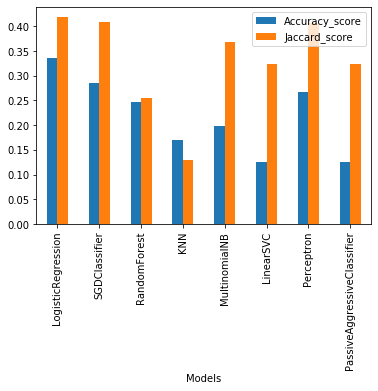

<Figure size 2160x1080 with 0 Axes>

In [48]:
score_AccuracyJaccard_df = pd.DataFrame({
    'Models': ['LogisticRegression', 'SGDClassifier',
               'RandomForest', 'KNN', 'MultinomialNB', 'LinearSVC',
               'Perceptron', 'PassiveAggressiveClassifier'],
    'Accuracy_score': [accuracy_score_logr,
                       accuracy_score_sgd,
                       accuracy_score_rand,
                       accuracy_score_knn,
                       accuracy_score_mnb,
                       accuracy_score_lsvc,
                       accuracy_score_prpt,
                       accuracy_score_pac],
    'Jaccard_score': [jaccard_score_logr,
                      jaccard_score_sgd,
                      jaccard_score_rand,
                      jaccard_score_knn,
                      jaccard_score_mnb,
                      jaccard_score_lsvc,
                      jaccard_score_prpt,
                      jaccard_score_pac]})
ax = plt.gca()
score_AccuracyJaccard_df.plot(kind='bar', x='Models',
                              y=['Accuracy_score', 'Jaccard_score'], ax=ax)
plt.figure(figsize=(30, 15))
plt.show()

###  Test sur formulaire :

#### Prediction avec Logistic regression :

In [18]:
# model = sgd_linear_clf_fit
# model = log_reg_clf_fit
# model = lsvc_clf_fit
model = knn_clf_fit
textInput = " javascript the definitive guide to form based website authentication form based authentication for websites we believe that stack overflow should not just be a resource for very specific technical questions, but also for general guidelines on how to solve variations on common problems."
# textInput = df[(df['Id'] == 53645882)]['BodyTitle']
most_freq_words = top1000words_exp
most_freq_tags = top100tags_exp

In [19]:
tagslist = predictTag(model, textInput, top1000words_exp, top100tags_exp)
print(tagslist)

[]
